# Make forward model (Y) with AVISO data

In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt
from aviso_rossby_wave import skill_matrix, reverse_vector, build_h_matrix
from aviso_rossby_wave import forecast_ssh, inversion

## Starting Date

In [2]:
day0, day1 = 0, 10 # 2016-06-01
time_range = 50 #(day1 - day0) * 2 + 1  # forecast time range
exp = 1 # R_over_P = K^-1

### Stratification paramters

## Subset 10 degree by 10 degree of ocean
### the aviso data is sampled at 5-day intervals

In [3]:
lonidx_west, lonidx_east = 60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
SSHA.shape

(40, 40, 150)

In [5]:
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [6]:
#ssha_time_mean = SSHA[:].mean(axis = -1)
ssha_time_mean = SSHA[day0 : day0 + 30].mean(axis = 0) # remove 150-day mean insead of multi-year mean (climatology)

In [7]:
SSHA = SSHA - ssha_time_mean # remove 150-day mean  SSHA[day0 + day0 + 30].mean(axis = -1) 
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

#### MSLA is the AVISO SSH anomalies to fit
#### Fit multiple days of SSH anomalies: day0 to day1

In [8]:
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 

In [9]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

In [10]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()

In [11]:
SSH0 = avisso_ds.msla[:, :, day0]
SSHA0 = SSH0 - avisso_ds.msla.mean(axis = -1)

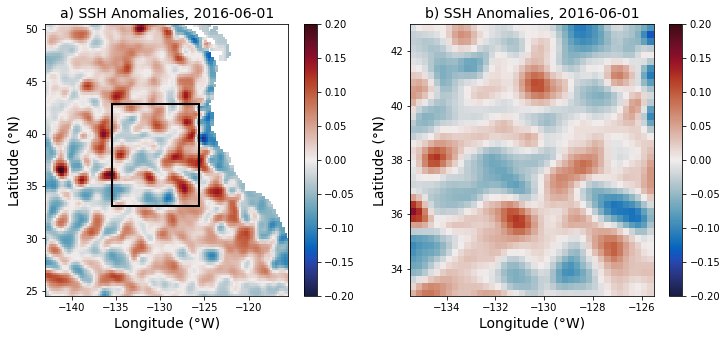

In [12]:
plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title('a) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
plt.pcolor((360 - avisso_ds.lon[30:140]) * -1, avisso_ds.lat, SSHA0[:, 30:140], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)

import matplotlib.patches as mpatches

#left, bottom, width, height = ((360 - avisso_ds.lon[lonidx_west].data) * -1, avisso_ds.lat[latidx_south],
#                               avisso_ds.lon[lonidx_west] - avisso_ds.lon[lonidx_east],
#                               avisso_ds.lat[latidx_north]- avisso_ds.lat[latidx_south])
left, bottom, width, height = (lon[0], lat[0],
                               lon[-1] - lon[0],
                               lat[-1]- lat[0])
rect=mpatches.Rectangle((left,bottom),width,height, #latidx_south:latidx_north, 
                        fill=False,
                        color="black",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
    
plt.colorbar()
plt.subplot(122)
plt.title('b) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
plt.pcolor(lon, lat, SSHA[:, :, day0], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.savefig('AVISO_SSHA_10deg'+ str(date_time[0])[:10]  +'.png')

### parameters

In [13]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 =  2 * Omega * np.sin(Phi0) #1.0313e-4 
f0, Beta

(4.309199134434463e-05, 2.1796846310544133e-06)

#### Rossby wave vertical modes

In [14]:
MModes = 1

#### define wavenumber interval based on domain size

In [15]:
L_lat = 10 # domain latitude length degree 
L_lon = 10 # domain lognitude length

domain_factor = 1.1 # the smaller, the less waves

k_interval = 2 * np.pi / (domain_factor * L_lat) # zonal wavemenumber interval
l_interval = 2 * np.pi / (domain_factor * L_lon) # longitutional wavemenumber interval

lamda_min = 1.2 # 100km = 1 degree minimum wavelength resolved , the smaller, the more waves

k_min = 0
k_max = 2 * np.pi / lamda_min
l_max = k_max
l_min = -1 * l_max
print(k_max)

5.235987755982989


In [16]:
k_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1
l_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
k_n = k_n_orig.reshape(len(k_n_orig), MModes) #* 0 # lon, zonal propagration 
l_n = l_n_orig.reshape(len(l_n_orig), MModes) #* 0 # lat, meridonal propagration

In [17]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

#### Wavespeed and Rossby wave deformation radius

In [18]:
Psi = strat_ds.Psi.data
Rm = 5e4  / 1e5 # 50 km to degree
wavespeed = Rm * f0  # deg / s strat_ds.C2[:MModes].data
Rm = np.array([Rm]) #unit: degree 
wavespeed, Rm , np.sqrt(strat_ds.C2[:MModes].data)/1e5 # deg/s

(2.1545995672172316e-05, array([0.5]), array([2.85035991e-05]))

#### evalucate the skill of each wave

In [19]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)

#### Number of models/waves

In [20]:
M = l_n.size * k_n.size
M

190

In [21]:
kk, ll = np.meshgrid(k_n, l_n)

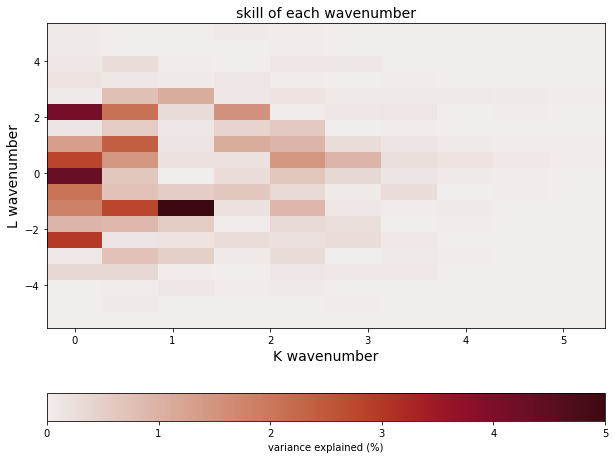

In [22]:
plt.figure(figsize = (10, 8))
plt.pcolor(kk, ll, skill[:, :, 0] * 100, cmap = cmo.cm.amp, vmin = 0, vmax = 5)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal', label = 'variance explained (%)')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_AVISO.png')
#plt.savefig('./skill_matrix_' + str(M) + '.png')

#### Signal to noise ratio matrix

In [23]:
counter = 0

kl, P_over_R = np.zeros(2 * M), np.zeros([2 * M, 2 * M])

for kk in k_n:
    for ll in l_n:
        kl[2*counter] = np.sqrt(kk ** 2 + ll ** 2)
        kl[2*counter+1] = np.sqrt(kk ** 2 + ll ** 2)
        P_over_R[2*counter, 2*counter] = kl[2*counter] ** exp
        P_over_R[2*counter+1, 2*counter+1] = kl[2*counter + 1] ** exp
        counter += 1

In [24]:
H_all = build_h_matrix(MSLA0, MModes, k_n, l_n, lon, lat, T_time[day0:], Psi, Rm, day0)

#### solve for amplitudes

In [25]:
amp, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R)

### Fit AVISO data to Rossby wave model

In [26]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse  = np.zeros(time_range)
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(time_range):
    # SSH data
    MSLA = SSHA_masked[:, :, day0+day: day0+day+1]
    # Build basis function H matrix
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 + day)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(MSLA, amp,  H_all)
    # reverse vector
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])

#     plt.figure(figsize = (15, 5))

#     plt.subplot(131)
#     plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('a) AVISO data ' + str(date_time[day])[:10], fontsize = 14)

#     plt.subplot(132)
#     plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('b) Rossby wave model, 450 waves', fontsize = 14)

#     residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
#     plt.subplot(133)
#     plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('c) Residual variance ' + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    
#     plt.tight_layout()
#     #plt.close()
#     plt.savefig('./forward_model/diag_ssh_' + str(date_time[day0+day])[:10] +'_' + str(skill.size) + 'waves.png', dpi = 300)

In [27]:
ds_output = xr.Dataset(data_vars={'k_n' : k_n[:, 0],
                                  'l_n' : l_n[:, 0],
                                  'Amplitudes': amp,
                                  'variance_explained': (('time'), 1-variance_explained_inverse),
                                  'MSLA_forward' : (('YC', 'XC', 'time'), MSLA_fwrd[:, :, :time_range]),
                                  'Rm': Rm,
                                  'XC' : (('XC'), lon.data), 
                                  'YC' : (('YC'), lat.data),
                                  'time': date_time[:time_range]},
                      attrs = dict(description=('Data sample of the selected waves, amplitudes, estimated SSH anomalies and residual, fit with ' 
                                                + str(day1 - day0) + '-day prior data.')))

In [28]:
'residual variance', variance_explained_inverse, date_time[:time_range]

('residual variance',
 array([0.48105622, 0.39324856, 0.31177685, 0.25348581, 0.21698041,
        0.20790164, 0.23331335, 0.28594032, 0.34532945, 0.41078481,
        0.48362428, 0.55842861, 0.63407736, 0.64573038, 0.71319191,
        0.77526633, 0.83241718, 0.88821991, 0.94040833, 0.97879659,
        0.98593277, 1.01437207, 1.0296843 , 1.03371097, 1.03050658,
        1.02411725, 1.0123501 , 1.00379105, 0.99652265, 0.99088093,
        0.98624807, 0.98354154, 0.98353321, 0.98413725, 0.98574435,
        0.98826345, 0.99219383, 0.99664384, 0.99858496, 0.99755181,
        0.99661497, 1.00262833, 1.01275601, 1.02539468, 1.03690369,
        1.04430618, 1.04432159, 1.03427469, 1.0261168 , 1.02284079]),
 array(['2016-06-01T00:00:00.000000000', '2016-06-06T00:00:00.000000000',
        '2016-06-11T00:00:00.000000000', '2016-06-16T00:00:00.000000000',
        '2016-06-21T00:00:00.000000000', '2016-06-26T00:00:00.000000000',
        '2016-07-01T00:00:00.000000000', '2016-07-06T00:00:00.000000000',


Text(0.5, 1.0, 'residual')

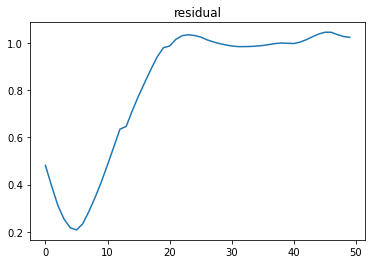

In [29]:
plt.plot(variance_explained_inverse[:])
plt.title('residual')

In [30]:
#ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(l_n.size * k_n.size) +'waves.nc')
ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(l_n.size * k_n.size) +'waves_data'+ str(int((day1 - day0)*5)) +'days.nc')

### Plot the Rossby wave model versus the AVISO data

In [31]:
time = T_time[:time_range] / 86400

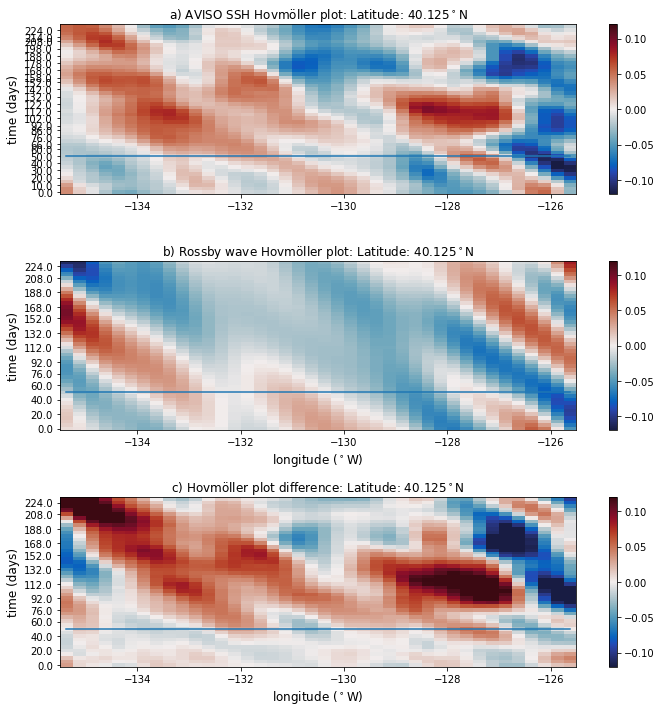

In [32]:
selected_lat = 28
plt.figure(figsize = (10, 10))     
SSHA_slice= SSHA_masked[selected_lat, :, day0:day0+time_range].T
plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0],  len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice - MSLA_fwrd[selected_lat, :, :time_range].T,cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
plt.savefig('./hovmoller/diag_Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

In [33]:
time

array([736482., 736487., 736492., 736497., 736502., 736507., 736512.,
       736517., 736522., 736527., 736532., 736537., 736542., 736543.,
       736548., 736553., 736558., 736563., 736568., 736573., 736574.,
       736579., 736584., 736589., 736594., 736599., 736604., 736609.,
       736614., 736619., 736624., 736629., 736634., 736635., 736640.,
       736645., 736650., 736655., 736660., 736665., 736670., 736675.,
       736680., 736685., 736690., 736695., 736696., 736701., 736706.,
       736711.])

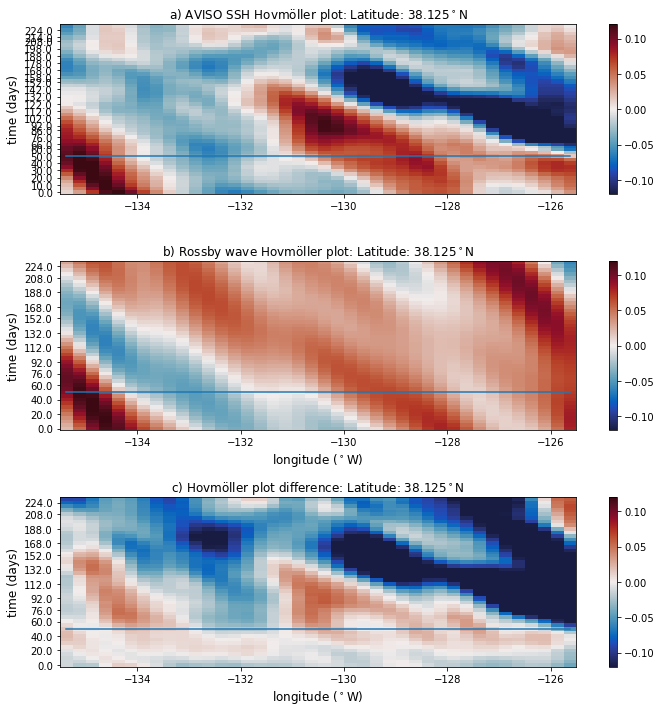

In [34]:
selected_lat = 20
plt.figure(figsize = (10, 10))

SSHA_slice = SSHA_masked[ selected_lat, :, day0:day0+time_range].T
plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice - MSLA_fwrd[selected_lat, :, :time_range].T,
               cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
plt.savefig('./hovmoller/diag_Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

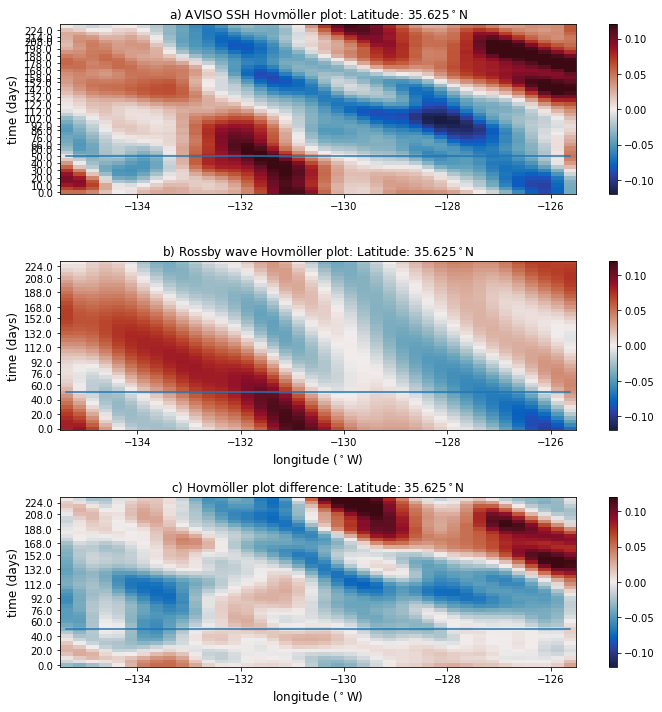

In [35]:
selected_lat = 10
plt.figure(figsize = (10, 10))

plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time,  SSHA_masked[ selected_lat,:, day0:day0+time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[ selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_masked[ selected_lat, :, day0:day0+time_range].T - MSLA_fwrd[selected_lat, :, :time_range].T,
               cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
plt.savefig('./hovmoller/diag_Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

## Diagnostics

### Phase speed is faster for longer waves. the maximum zonal phase speed is Cx = $\beta * R^2$. For those waves, the propagration speed for the ROssby waves: 

In [36]:
Beta * Rm ** -2, 'degree/s', Beta * Rm ** -2 * 1e5, 'm/s'

(array([8.71873852e-06]), 'degree/s', array([0.87187385]), 'm/s')

In [37]:
Beta * Rm ** -2  * 86400 * 20, 'degree per 20 days',Beta * Rm ** -2 * 1e5 * 86400 * 20 /1000, 'km'

(array([15.06598017]), 'degree per 20 days', array([1506.59801698]), 'km')

### Compare persistence error to forecast error: do wave dynamics predict SSH anomalies better than persistence? 

## plot persistence versus prediction error

In [38]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
prediction_err = MSLA_fwrd[:, :, :time_range] - SSHA.data[:, :, day0:day0+time_range]
rms_persistence = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t :day0 + 1 + t].data ** 2)) 
    # day by day persistence
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t].data ** 2))

In [39]:
rms_persistence

array([0.        , 0.19175088, 0.3506551 , 0.48960993, 0.60503095,
       0.71346084, 0.80698003, 0.87959458, 0.92693545, 0.95941833,
       0.97099742, 0.97680495, 0.99156207, 0.9954911 , 1.01714729,
       1.04460493, 1.07024068, 1.09362569, 1.11332096, 1.12925165,
       1.13119856, 1.13851695, 1.14058579, 1.14252588, 1.14080074,
       1.13820899, 1.12929575, 1.11912584, 1.1138333 , 1.1136013 ,
       1.11528478, 1.11802775, 1.12172799, 1.12327532, 1.12541961,
       1.1265786 , 1.12800732, 1.13302299, 1.14167284, 1.15295475,
       1.16474451, 1.18400117, 1.20515792, 1.22033569, 1.23140932,
       1.23806605, 1.23829408, 1.2356369 , 1.23152679, 1.22522898])

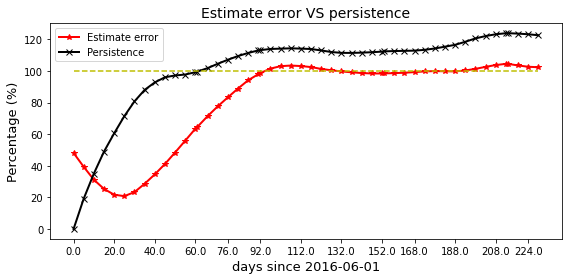

In [40]:
plt.figure(figsize = (8, 4))
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error')
plt.plot(time[:time_range], (rms_persistence[:time_range]) * 100,  
         '-x',linewidth = 2, color = 'k', label = 'Persistence')
plt.plot(time, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
plt.xticks(time[:time_range][0::4], time[:time_range][0::4] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('days since ' + str(date_time[0])[:10], fontsize = 13)
plt.title('Estimate error VS persistence', fontsize = 14)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/diag_estimate_err_vs_persistence_' + str(date_time[day0])[:10] + '.png', dpi = 300)

### Make an ensemble of persistence

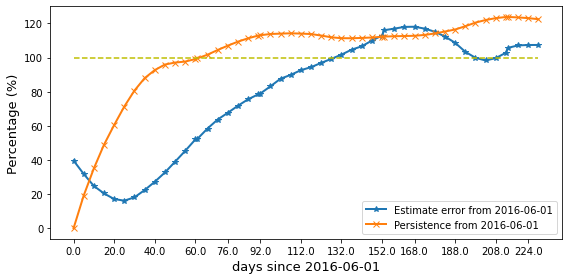

In [41]:
persistence0 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
persistence1 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day1:day1+1]
prediction_err = MSLA_fwrd[:, :, :time_range] - SSHA.data[:, :, day0:day0+time_range]
rms_persistence0 = np.zeros(persistence.shape[-1])
rms_persistence1 = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])

for t in range(persistence.shape[-1]):
    rms_persistence0[t] = np.sqrt(np.mean(persistence0[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2)) # day 0
    rms_persistence1[t] = np.sqrt(np.mean(persistence1[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2)) # day 70
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2))
    
plt.figure(figsize = (8,4))
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2,  label = 'Estimate error from ' + str(date_time[day0])[:10])
plt.plot(time[:time_range], (rms_persistence0[:time_range]) * 100,  
         '-x',linewidth = 2,  label = 'Persistence from ' + str(date_time[day0])[:10])
#plt.plot(time[:time_range], (rms_persistence1[:time_range]) * 100,  
#         '-x',linewidth = 2, label = 'Persistence from ' + str(date_time[day1])[:10])
plt.plot(time, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
plt.xticks(time[:time_range][0::4], time[:time_range][0::4] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('days since ' + str(date_time[0])[:10], fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/diag_fwd_prediction_err_vs_persistence_' 
            + str(M) + '_waves_' + str(int((day1 - day0)*5)) + 'days.png', dpi = 300)